In [1]:
import os, sys
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir,'..')))

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from scripts.data_load import load_data
import joblib

In [8]:
df_woe = load_data("../data/woe_transformed_data.csv")

In [9]:
df_woe.fillna(0, inplace=True)

In [11]:
# Split features (X) and target (y)
X = df_woe.drop(columns=['target']) 
y = df_woe['target']

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

In [14]:
# Hyperparameter tuning using GridSearchCV
logistic_params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']}
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5, scoring='roc_auc')
logistic_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
             scoring='roc_auc')

In [15]:
# Best Logistic Regression model
logistic_best = logistic_grid.best_estimator_

In [16]:
# Initialize Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

In [17]:
# Hyperparameter tuning using GridSearchCV
rf_params = {'n_estimators': [50, 100, 200],
             'max_depth': [5, 10, 20],
             'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(random_forest_model, rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [18]:
# Best Random Forest model
rf_best = rf_grid.best_estimator_

In [19]:
# Define function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for ROC-AUC
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
    }
    return metrics, y_pred, y_proba

In [20]:
# Evaluate Logistic Regression
logistic_metrics, logistic_pred, logistic_proba = evaluate_model(logistic_best, X_test, y_test)

c:\Users\USER\Documents\10X Exercises\Week-6-Bati-Bank\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Evaluate Random Forest
rf_metrics, rf_pred, rf_proba = evaluate_model(rf_best, X_test, y_test)

c:\Users\USER\Documents\10X Exercises\Week-6-Bati-Bank\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
def plot_roc_curve(y_test, logistic_proba, rf_proba):
    fpr_log, tpr_log, _ = roc_curve(y_test, logistic_proba)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = {:.3f})'.format(logistic_metrics['ROC-AUC']))
    plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.3f})'.format(rf_metrics['ROC-AUC']))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

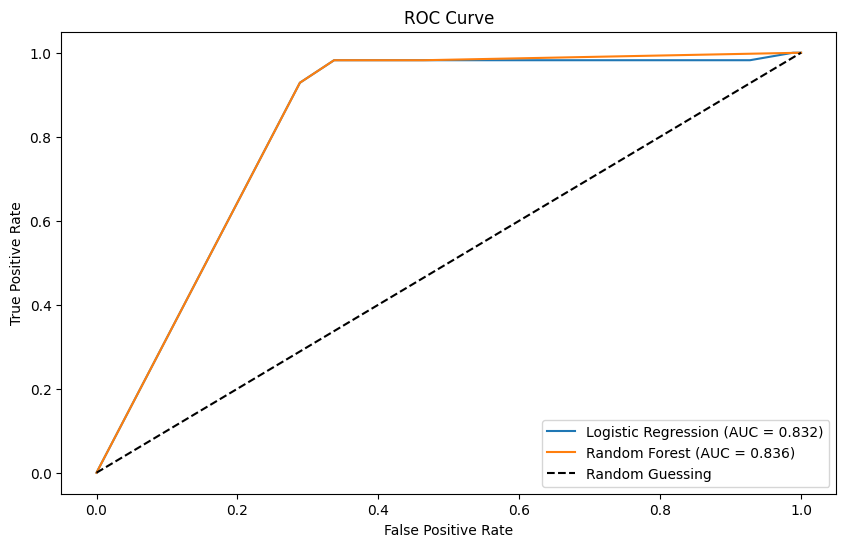

In [23]:
plot_roc_curve(y_test, logistic_proba, rf_proba)

In [24]:
# Save model performance metrics
performance_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
                               'Logistic Regression': logistic_metrics.values(),
                               'Random Forest': rf_metrics.values()})
performance_df.to_csv('../data/model_performance_metrics.csv', index=False)

In [25]:
# Save predictions
predictions_df = pd.DataFrame({'y_true': y_test, 
                               'Logistic Regression': logistic_pred, 
                               'Random Forest': rf_pred})
predictions_df.to_csv('../data/model_predictions.csv', index=False)

In [27]:
# Save the Logistic Regression model
joblib.dump(logistic_best, '../data/logistic_model.pkl')

# Save the Random Forest model
joblib.dump(rf_best, '../data/random_forest_model.pkl')

print("Models have been saved as .pkl files!")

Models have been saved as .pkl files!
